# Proyecto n° 1
## Módulo 6: Técnicas de Análisis de Datos

*Carla Iturriaga Barrios*

*18.739.444-9*

*Agosto, 2022*

### Presentación del proyecto.

*Una empresa dedicada a la compra y venta de vehículos usados, donde la **compra es anticipada** y la **venta es por modalidad de remate y venta al mejor postor**, obtiene pérdidas inmediatas a la hora de rematar algunos de sus vehículos, puesto que compran o aseguran el vehículo a un precio más alto del que, finalmente, se vende.*

*A raíz de esto, **la empresa busca asegurar los vehículos a un precio igual o más bajo que el de adjudicación**.*

### Objetivo del proyecto.

1. *Construir un modelo que sea capaz de predecir el precio de venta de autos usados a partir de los resultados históricos de venta.*

In [1]:
import codigo.dataset as d
import codigo.models as m
import codigo.metrics as me
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy
from scipy import stats

### 1. Datos

**Corresponden a una base de datos histórica de las adjudicaciones de vehículos dentro de remates realizados entre 2019 y 2020.**

**Cada registro entrega información sobre el vehículo, tales como año, kilometraje, unidad de origen, tracción, etc. Junto a su precio de venta/adjudicación.**

*En adelante, se utilizaran las funciones definidas en el módulo `set_datos.py` para facilitar la gestión y manejo de los datos.*

In [2]:
help(d.load_result)
data = d.load_result()
X, y = data['dataset']

Help on function load_result in module codigo.dataset:

load_result(URL='https://raw.githubusercontent.com/citurriagab/Data_Hist_Resultados/main/RESULTADO_2019_2020.csv')
    Va a buscar los resultados entre 2019 y 2020 de las adjudicaciones de vehículos en remates de la compania. Retorna "X / input" o variables dependientes (características del vehículo) e "y / output" correspondiente al precio de venta.'.

Datos cargados con éxito


Las dimensiones del *dataset* [Resultados_2019_2020](https://raw.githubusercontent.com/citurriagab/Data_Hist_Resultados/main/RESULTADO_2019_2020.csv) son las siguientes:

*Correspondientes a 5.436 registros de vehículos rematados entre los años definidos anteriormente, presentados en 7 diferentes variables dependientes sumado a la independiente.*

In [3]:
X.shape, y.shape

((5434, 7), (5434,))

#### Previsualización del dataset 

*Al realizar una previsualización de los datos, se obtiene lo siguiente:*

In [4]:
X.head(5)

,LOTE,UNIDAD,TIPO,ANHO,TRACC,COMB,KILOMETRAJE
0,1,BFE,STATION WAGON,2018,4x4,B,41090
1,2,PARTICULARES,STATION WAGON,2018,4x2,D,113459
2,3,BFE,STATION WAGON,2017,4x4,B,32154
3,4,BFE,STATION WAGON,2020,4x2,B,13109
4,5,PARTICULARES,STATION WAGON,2020,4x4,B,2066


In [5]:
y.head(5)

0    23100000
1    14400000
2    14700000
3    13000000
4    13600000
Name: ADJUDIC, dtype: int64

**Preparación de los datos categóricos (dummies)**

*Para llevar a cabo el siguiente análisis y construcción del modelo, previamente se trabajan las variables categóricas conviertiendolas en dummies*

In [6]:
X['UNIDAD'] = X['UNIDAD'].astype('category')
X['TIPO'] = X['TIPO'].astype('category')
X['TRACC'] = X['TRACC'].astype('category')
X['COMB'] = X['COMB'].astype('category')

In [7]:
## dummies unidad
unid_d = pd.get_dummies(X['UNIDAD'])
## dummies tipo
tipo_d = pd.get_dummies(X['TIPO'])
## dummies traccion
tracc_d = pd.get_dummies(X['TRACC'])
## dummies combustible
comb_d = pd.get_dummies(X['COMB'])
comb_d = comb_d.rename(columns={'B':'Bencina',
                                   'D':'Diesel'})


In [8]:
##dummies unidad
X2 = pd.concat([X, unid_d['AUTOMOTORAS']], axis=1)
X2 = pd.concat([X2, unid_d['BFE']], axis=1)
X2 = pd.concat([X2, unid_d['LEASING']], axis=1)
X2 = pd.concat([X2, unid_d['LIQUIDACIONES']], axis=1)
X2 = pd.concat([X2, unid_d['PARTICULARES']], axis=1)
X2 = pd.concat([X2, unid_d['RENOVACIÓN ANTICIPADA']], axis=1)
##dummies tipo
X2 = pd.concat([X2, tipo_d['AMBULANCIA']], axis=1) 
X2 = pd.concat([X2, tipo_d['CAMION']], axis=1) 
X2 = pd.concat([X2, tipo_d['CAMIONETA']], axis=1) 
X2 = pd.concat([X2, tipo_d['FURGON']], axis=1) 
X2 = pd.concat([X2, tipo_d['HATCHBACK']], axis=1) 
X2 = pd.concat([X2, tipo_d['MINIBUS']], axis=1) 
X2 = pd.concat([X2, tipo_d['MOTOS']], axis=1) 
X2 = pd.concat([X2, tipo_d['SEDAN']], axis=1)   
X2 = pd.concat([X2, tipo_d['STATION WAGON']], axis=1) 
X2 = pd.concat([X2, tipo_d['SUV/JEEP']], axis=1)
##dummies traccion                 
X2 = pd.concat([X2, tracc_d['2x2']], axis=1)   
X2 = pd.concat([X2, tracc_d['4x2']], axis=1) 
X2 = pd.concat([X2, tracc_d['4x4']], axis=1)  
##dummies combustible
X2 = pd.concat([X2, comb_d['Bencina']], axis=1)
X2 = pd.concat([X2, comb_d['Diesel']], axis=1)

## eliminación de columnas categóricas originales.
X2 = X2.drop(['UNIDAD'], axis=1)
X2 = X2.drop(['TIPO'], axis=1)
X2 = X2.drop(['TRACC'], axis=1)
X2 = X2.drop(['COMB'], axis=1)

*El nuevo dataset con la transformación de las variables categoricas, se compone de **28 columnas** en su X explicativa*

**Previsualización de las nuevas variables explicativas X del dataset**

In [9]:
X2.shape

(5434, 24)

In [10]:
X2.head(3)

,LOTE,ANHO,KILOMETRAJE,AUTOMOTORAS,BFE,LEASING,LIQUIDACIONES,PARTICULARES,RENOVACIÓN ANTICIPADA,AMBULANCIA,...,MINIBUS,MOTOS,SEDAN,STATION WAGON,SUV/JEEP,2x2,4x2,4x4,Bencina,Diesel
0,1,2018,41090,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,1,0
1,2,2018,113459,0,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,1
2,3,2017,32154,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,1,0


#### Análisis Estadístico

**¿Existen valores nulos o indeterminados en la variable independiente "Adjudicación"**

In [11]:
y.isna().sum()

0

*No existen registros con información indeterminada en la "adjudicación", es decir, la base de datos consta de todos los vehículos que fueron rematados a un determinado precio de venta*

**Estadística básica de la variable independiente "Adjudicación":**

In [12]:
y.describe()

count    5.434000e+03
mean     6.207532e+06
std      2.694229e+06
min      3.300000e+05
25%      4.400000e+06
50%      5.900000e+06
75%      7.600000e+06
max      4.550000e+07
Name: ADJUDIC, dtype: float64

*El precio de venta o adjudicación de los vehículos se mueve entre $330.000 y $45.500.000. Lo cual indica desde un principio que existen bienes que la brecha es grande entre el vehículo que se remata más barato en contraste con el más caro.*

*Además, la media y la mediana se distancian en $300.000, con una media mayor que la mediana, **indicando una distribución sesgada a la derecha**.*

**Identificación de valores outliers en variable independiente "Adjudicación"**

Limite inferior:  -400000.0
Limite superior:  12400000.0
Registros sobre el limite sup:  129


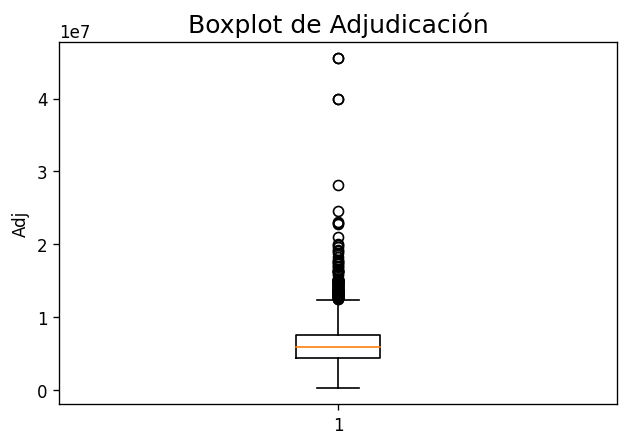

In [13]:
plt.figure(dpi=120);
plt.boxplot(y)
plt.title('Boxplot de Adjudicación', fontsize=15)
plt.ylabel('Adj', fontsize=10)
plt.text(6.5, -3.25, '')

#cuartiles
q3, q1 = np.percentile(y, [75, 25])
iqr = q3-q1
lim_sup = q3 + (1.5*iqr)
lim_inf = q1 - (1.5*iqr)

# limites
print('Limite inferior: ', lim_inf)
print('Limite superior: ', lim_sup)
print('Registros sobre el limite sup: ', y[y>lim_sup].count())

*De acuerdo al gráfico de boxplot anterior, se obtiene que la variable "Adjudicación" presenta valores atípicos al sobrepasar el precio de venta de $12.400.000, concentrando su movimiento bajo dicho valor.*

*Son **129 las observaciones outliers**, significando el **2,3% de la base total**. Sin embargo, se asume que se debe a autos de lujo o con características especiales que será importante conservar dentro del análisis. Por lo que, **se decide no excluir ni imputar dichas adjudicaciones atípicos**.*

**Distribución de la variable independiente "Adjudicación"**

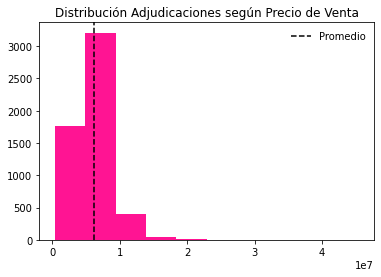

In [14]:
plt.hist(y, color="deeppink");
plt.axvline(y.mean(), linestyle='--', label='Promedio', color='black');
plt.title('Distribución Adjudicaciones según Precio de Venta');
plt.legend(frameon=False);

**Distribución de la variable independiente "Adjudicación" sin outliers**

*El gráfico de distribución del precio de venta puede ser más claro y excluimos los valores atípicos, sólo para efectos visuales*


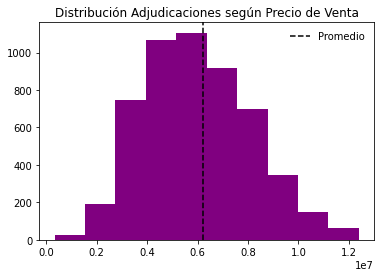

In [15]:
y1 = y[y<=lim_sup]

plt.hist(y1, color="purple");
plt.axvline(y.mean(), linestyle='--', label='Promedio', color='black');
plt.title('Distribución Adjudicaciones según Precio de Venta');
plt.legend(frameon=False);

*Al excluir los valores outliers de la muestra para visualizar la **distribución de la adjudicación**, el comportamiento parece ser normal, formando una campana de gauss casi perfecta.*

*Sin embargo, como anteriormente se mencionó, la media toma un valor menor que la mediana, presentando un pequeño sesgo hacia la derecha.*

**Preparación de la base de datos: Entrenamiento y Testeo**

*Previo a construir el modelo, se dividirá la base de datos total en dos, ello con la intención de que el modelo conozca y trabaje con determinados datos "de Entrenamiento" y pueda probar su efectividad en datos desconocidos "de Testeo".*

*La base de Entrenamiento se preparará con el 90% de los datos: 4.892 registros, mientras que se probarán resultados con los 544 restantes.*

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.1, random_state=42)

In [18]:
X_train.shape, X_test.shape

((4890, 24), (544, 24))

In [19]:
y_train.shape, y_test.shape

((4890,), (544,))

**Visualizaciones con la Data a Entrenar**

* *Gráfico de dispersión del **Precio de adjudicación/venta** respecto al **Tipo de vehículo** y **Año de fabricación**.*

*La siguiente visualización expresa que mientras más nuevo es el vehículo, más alto es su precio de venta y que entre menos uso del vehículo más caro se vende (km)*

*Sin embargo, dentro del mismo gráfico, se presentan anomalías indicando que, dentro de los resultados históricos, vehículos con fecha de fabricación cercana al 2016, tienen resultados favorables a pesar de presentar altos kilometrajes (excesivos respecto al resto), de acuerdo a los colores más oscuros de los puntos.*

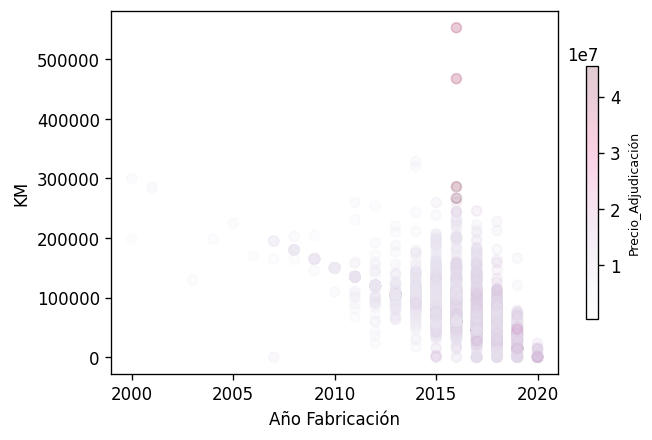

In [20]:
plt.figure(dpi=120);
CMAP='PuRd'
plt.scatter(X_train['ANHO'], X_train['KILOMETRAJE'], c=y_train, 
            cmap=CMAP, alpha=.2);
plt.colorbar(orientation='vertical', shrink=0.7).set_label(label='Precio_Adjudicación', size=7.5);
plt.xlabel('Año Fabricación');
plt.ylabel('KM');

### 2. Modelos

**Se llevará a cabo la construcción de 2 Modelos de Regresión: Lineal múltiple y Vecino más cercano, con las diferentes variables dependientes (características del vehículo) y la variable independiente (precio de adjudicación/venta).**

*En adelante, se utilizaran las funciones definidas en el módulo `modelo.py` para facilitar la gestión y construcción del modelo.*

* Entrenamiento de modelos de Regresión: Lineal y KNN. 

*Se utilizan datos de entrenamiento para la construcción del modelo (90% de la base)*

In [22]:
mod_reg_lineal = m.reg_lineal(X_train, y_train.values.ravel())
modelo_reg_KNN = m.reg_KNN(X_train, y_train.values.ravel())

* Predicción con modelos de Regresión: Lineal y KNN. 

*Ya creado y entrenado el modelo, se utilizan los datos que, anteriormente, se separaron de la base para testeo (10% de la base)*

In [23]:
reg_lineal_pred = mod_reg_lineal.predict(X_test)
reg_knn_preds = modelo_reg_KNN.predict(X_test)

### 3. Métricas de Evaluación

**Con el entrenamiento de los modelos de regresión Lineal y KNN, se procesó la predicción de los datos de testeo y para comprobar y evaluar qué tan buenos son los modelos recientemente presentados, se llevará a cabo el cálculo de métricas asociadas al éxito del modelo al predecir datos.**

*En adelante, se utilizaran las funciones definidas en el módulo `metricas.py` para facilitar la evaluación y comprobación del éxito de los modelos.*

* Desempeño de los modelos según Coeficiente de Determinación:

In [24]:
print(f'Desempeño regresión lineal según r2: {me.met_r2(y_test, reg_lineal_pred)}')
print(f'Desempeño KNN regresión según r2: {me.met_r2(y_test, reg_knn_preds)}')

Desempeño regresión lineal según r2: 0.5076733845838555
Desempeño KNN regresión según r2: 0.39584460211051353


* Desempeño de los modelos según Error Cuadrático Medio:

In [25]:
print(f'Desempeño regresión lineal según MSE: {me.met_mse(y_test, reg_lineal_pred)}')
print(f'Desempeño KNN regresión según MSE: {me.met_mse(y_test, reg_knn_preds)}')

Desempeño regresión lineal según MSE: 3428307426164.4814
Desempeño KNN regresión según MSE: 4207025117647.0586


* Desempeño de los modelos según la Raíz del Error Cuadrático Medio:

In [26]:
print(f'Desempeño regresión lineal según RMSE: {me.met_rmse(y_test, reg_lineal_pred)}')
print(f'Desempeño KNN regresión según RMSE: {me.met_rmse(y_test, reg_knn_preds)}')

Desempeño regresión lineal según RMSE: 1851568.9093750957
Desempeño KNN regresión según RMSE: 2051103.3902870568


* Desempeño de los modelos según Error Cuadrático Medio Logarítmico:

In [27]:
print(f'Desempeño regresión lineal según MSLE: {me.met_msle(y_test, reg_lineal_pred)}')
print(f'Desempeño KNN regresión según MSLE: {me.met_msle(y_test, reg_knn_preds)}')

Desempeño regresión lineal según MSLE: 0.08488015353556222
Desempeño KNN regresión según MSLE: 0.118347362887648


* Desempeño de los modelos según Error Cuadrático Absoluto:


In [28]:
print(f'Desempeño regresión lineal según MAE: {me.met_mae(y_test, reg_lineal_pred)}')
print(f'Desempeño KNN regresión según MAE: {me.met_mae(y_test, reg_knn_preds)}')

Desempeño regresión lineal según MAE: 1295132.048445105
Desempeño KNN regresión según MAE: 1444022.0588235294


* Desempeño de los modelos según Error Absoluto Medio Porcentual:

In [29]:
print(f'Desempeño regresión lineal según MAPE: {me.met_mape(y_test, reg_lineal_pred)}')
print(f'Desempeño KNN regresión según MAPE: {me.met_mape(y_test, reg_knn_preds)}')

Desempeño regresión lineal según MAPE: 0.2311703921387609
Desempeño KNN regresión según MAPE: 0.2843911105853502


*Según lo expuesto con anterioridad, cada una de las métricas conceden como mejor modelo de predicción al Modelo de Regresión Lineal Múltiple por sobre el de KNN, de lo cual se puede decir lo siguiente:*

* **Lineal Múltiple obtuvo un mayor coeficiente de determinación R2**, *indicando que es capaz de predecir acertadamente en un 51% de los casos, mientras que el KNN, sólo el 40%*

* **Lineal Múltiple obtuvo un menor resultados en todas las métricas MSE, RMSE, MSLE, MAE y MAPE**, *indicando mejores índices en términos de predictor.*

*No obstante, si bien el Modelo de Regresión Lineal Múltiple se concluye como mejor modelo predictor, éste no es un modelo robusto, dado que se esperaría que su éxito en predicciones superara el 80%, al menos.*

*Por lo tanto, respecto al objetivo propuesto al inicio del proyecto, con la data propuesta no es posible construir un modelo que sea capaz de anticiparse y proveer de una predicción del precio de adjudicación de los vehículos que se comprarán en el futuro.*

*Posiblemente, se requieran mayores especificaciones del vehículo para otorgarle mayor robustez al modelo y ser capaces de predecir correctamente el precio de adjudicación.*
